In [843]:
import os 
import sys
from support_functions import *
from tensorflow import keras
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [844]:
# configure
n_seq = 30
n_test = 200
n_lag = 120
n_epochs = 20
n_batch = 1
n_neurons = 120

#index to the test case you want to plot
test_index = n_test-1

#Configure dataset
path = '/Users/torefossland/Documents/MAC0460/project/dataset/GlobalTemperatures.csv'
SELECTED = "LandAverageTemperature"

In [845]:
df = pd.read_csv(path)

#string to date format
df['Month'] = pd.to_datetime(df['dt'],infer_datetime_format=True)
df = df.set_index(['Month'])
df=df.dropna(axis=0)
display(df)
series = df[SELECTED]
display(series)

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
Month,,,,,,,,,
1850-01-01,1850-01-01,0.749,1.105,8.242,1.738,-3.206,2.822,12.833,0.367
1850-02-01,1850-02-01,3.071,1.275,9.970,3.007,-2.291,1.623,13.588,0.414
1850-03-01,1850-03-01,4.954,0.955,10.347,2.401,-1.905,1.410,14.043,0.341
1850-04-01,1850-04-01,7.217,0.665,12.934,1.004,1.018,1.329,14.667,0.267
1850-05-01,1850-05-01,10.004,0.617,15.655,2.406,3.811,1.347,15.507,0.249
...,...,...,...,...,...,...,...,...,...
2015-08-01,2015-08-01,14.755,0.072,20.699,0.110,9.005,0.170,17.589,0.057
2015-09-01,2015-09-01,12.999,0.079,18.845,0.088,7.199,0.229,17.049,0.058
2015-10-01,2015-10-01,10.801,0.102,16.450,0.059,5.232,0.115,16.290,0.062


Month
1850-01-01     0.749
1850-02-01     3.071
1850-03-01     4.954
1850-04-01     7.217
1850-05-01    10.004
               ...  
2015-08-01    14.755
2015-09-01    12.999
2015-10-01    10.801
2015-11-01     7.433
2015-12-01     5.518
Name: LandAverageTemperature, Length: 1992, dtype: float64

In [846]:
#Function to create the input data and the corresponding labels to be predicted
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [847]:
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
        raw_values = series.values
        
        # transform to stationary data
        diff_series = series.diff().dropna()
        diff_values = diff_series.values
        diff_values = diff_values.reshape(len(diff_values), 1)
        
        # rescale values
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaled_values = scaler.fit_transform(diff_values)
        scaled_values = scaled_values.reshape(len(scaled_values), 1)
        
        # transform into supervised learning problem X, y
        X, y = split_sequence(scaled_values, n_lag, n_seq)
        X_train, y_train = X[:-n_test], y[:-n_test]
        X_test, y_test = X[-n_test:], y[-n_test:]
        return scaler, X_train, y_train, X_test, y_test

scaler, X_train, y_train, X_test, y_test = prepare_data(series, n_test, n_lag, n_seq)

In [865]:
def evaluate_predictions(test, preds, n_lag, n_seq):
        rmse_list = []
        msle_list = []
        mae_list = []
        for i in range(n_seq):
            actual = [row[i] for row in test]
            predicted = [pred[i] for pred in preds]
            rmse = np.sqrt(mean_squared_error(actual, predicted))
            msle = mean_squared_log_error(actual, predicted)
            mae = mean_absolute_error(actual, predicted)
            rmse_list.append(rmse)
            msle_list.append(msle)
            mae_list.append(mae)
            print('t+%d RMSE: %f' % ((i+1), rmse), "\t", 't+%d MSLE: %f' % ((i+1), msle), "\t", 't+%d MAE: %f' % ((i+1), mae))
        return sum(rmse_list)/len(rmse_list), sum(msle_list)/len(msle_list), sum(mae_list)/len(mae_list)
                  

              t-1     t+1
Month                    
1850-01-01    NaN   0.749
1850-02-01  0.749   3.071
1850-03-01  3.071   4.954
1850-04-01  4.954   7.217
1850-05-01  7.217  10.004


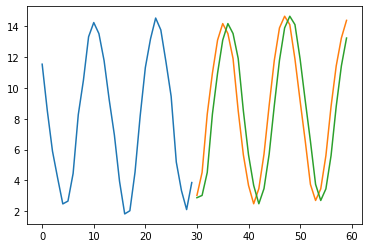

RMSE:  2.1662133904124867 	 MSLE:  0.06819431043262443 	 MAE:  1.921379056047198


In [869]:
# split into train and test sets
values = pd.DataFrame(series)
values = values.set_index(series.index)

dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
print(dataframe.head(5))

X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
 
# persistence model
def model_persistence(x):
    return x
# walk-forward validation
predictions = list()
for x in test_X:
	yhat = model_persistence(x)
	predictions.append(yhat)
    

# plot predictions and expected results
plt.plot(train_y[test_index:n_test+n_seq-1])
plt.plot([None for i in train_y[test_index:n_test+n_seq-1]] + [x for x in test_y[test_index:n_test+n_seq-1]])
plt.plot([None for i in train_y[test_index:n_test+n_seq-1]] + [x for x in predictions[test_index:n_test+n_seq-1]])
plt.show()

rmse = np.sqrt(mean_squared_error(test_y, predictions))
msle = mean_squared_log_error(test_y, predictions)
mae = mean_absolute_error(test_y, predictions)
print('RMSE: ', rmse, "\t", 'MSLE: ', msle, "\t", 'MAE: ', mae)

In [850]:
# Create a simple LSTM model
def create_model(X_train, y_train, n_lag, n_seq, n_batch, nb_epoch, n_neurons, noise):
        X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
        # Create model topology
        model = Sequential()
        model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X_train.shape[1], X_train.shape[2]), stateful=True, return_sequences=False))
        model.add(Dense(units = y_train.shape[1]))
        if noise:
            print("Added gaussian noise to model. ")
            model.add(GaussianNoise(0.1))
        model.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.MeanAbsoluteError()])
        return model

In [851]:
# Make a single prediction
def predict_lstm(model, X, n_batch):
    X = X.reshape(1, 1, len(X))
    # make prediction
    pred = model.predict(X, batch_size=n_batch)
    return [x for x in pred[0, :]]

In [852]:
#Function that loops through the test data and gets the predictions
def make_predictions(model, n_batch, X_test, n_lag, n_seq):
    preds = list()
    for i in range(X_test.shape[0]):
        pred = predict_lstm(model, X_test[i], n_batch)
        preds.append(pred)
    return preds

In [853]:
# Undo the differencing done to make data stationary
def inverse_difference(last_ob, pred):
    pred_cumsum = pred.cumsum()
    inverted = [last_ob]*len(pred)
    inverted = [sum(x) for x in zip(inverted, pred_cumsum)]
    return inverted

In [854]:
# Inversly transforms the data back to proper scale
def inverse_transform(series, preds, scaler, n_test):
    inverted = list()
    for i in range(len(preds)):
        # create array from pred
        pred = np.array(preds[i])
        pred = np.array(preds[i]).reshape(1, len(pred))

        # invert scaling
        inv_scale = scaler.inverse_transform(pred)
        inv_scale = inv_scale[0, :]

        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted

In [855]:
# plot the predictions in the context of the original dataset
def plot_predictions(series, preds, n_test, test_index):
    assert test_index<len(preds) and test_index>=0, \
        f'Please input a valid test_index. Must be larger than 0 and less than {len(preds)}'
    
    x_lim = int(len(series) * 0.95)
    y_lim_upper = max(np.max(preds), np.max(series[x_lim:])) * 1.01
    y_lim_lower = min(np.min(series[x_lim:]), np.min(preds))*0.99
    
    # plot the entire dataset in blue
    plt.figure(figsize=(16,8))
    plt.plot(series.values, '-o', label='Actual')
    
    # plot the prediction
    start_index = len(series) - n_test + test_index - 1
    end_index = start_index + len(preds[test_index]) + 1
    xaxis = [x for x in range(start_index, end_index)]
    yaxis = [series.values[start_index]] + preds[test_index]
    plt.plot(xaxis, yaxis, '-o', color='orange', label='Predicted')
        
    # show the plot
    plt.axis([x_lim, len(series)+len(preds[0]), y_lim_lower, y_lim_upper])
    plt.legend()
    plt.show()
    return




In [856]:
def make_prediction(X_train, y_train, n_lag, n_seq, n_batch, n_epochs, n_neurons, noise = False):
    model = create_model(X_train, y_train, n_lag, n_seq, n_batch, n_epochs, n_neurons, noise)

    #Have to rehsape the training data to fit the model [samples, 1, features]
    X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

    #Fit the model with the training data
    es = tf.keras.callbacks.EarlyStopping(patience=5, monitor='loss')
    for i in range(n_epochs):
        history = model.fit(X_train_reshaped, y_train, epochs=1, verbose=1, batch_size=n_batch, shuffle=False, callbacks=[es])
        model.reset_states()

    # make predictions
    preds = make_predictions(model, n_batch, X_test, n_lag, n_seq)

    # inverse transform forecasts and test
    preds = inverse_transform(series, preds, scaler, n_test+n_seq-1)
    actual = [row.reshape(-1) for row in y_test]
    actual = inverse_transform(series, actual, scaler, n_test+n_seq-1)
    return actual, preds


actual, preds = make_prediction(X_train, y_train, n_lag, n_seq, n_batch, n_epochs, n_neurons)


1642/1642 [==============================] - 1s 526us/step - loss: 0.0070 - mean_absolute_error: 0.0629


In [867]:
# evaluate predictions
rmse_avg, msle_avg, mae_avg = evaluate_predictions(actual, preds, n_lag, n_seq)
print("rmse_avg: ",rmse_avg, "msle_avg: ", msle_avg,"mae_avg: ", mae_avg )

t+1 RMSE: 0.367811 	 t+1 MSLE: 0.003450 	 t+1 MAE: 0.281363
t+2 RMSE: 0.428876 	 t+2 MSLE: 0.004188 	 t+2 MAE: 0.335454
t+3 RMSE: 0.532505 	 t+3 MSLE: 0.005739 	 t+3 MAE: 0.403915
t+4 RMSE: 0.574479 	 t+4 MSLE: 0.005114 	 t+4 MAE: 0.421498
t+5 RMSE: 0.610699 	 t+5 MSLE: 0.004595 	 t+5 MAE: 0.424666
t+6 RMSE: 0.605909 	 t+6 MSLE: 0.004586 	 t+6 MAE: 0.415425
t+7 RMSE: 0.583887 	 t+7 MSLE: 0.005029 	 t+7 MAE: 0.433264
t+8 RMSE: 0.539991 	 t+8 MSLE: 0.004873 	 t+8 MAE: 0.415448
t+9 RMSE: 0.515914 	 t+9 MSLE: 0.005325 	 t+9 MAE: 0.411327
t+10 RMSE: 0.532353 	 t+10 MSLE: 0.005439 	 t+10 MAE: 0.403097
t+11 RMSE: 0.568601 	 t+11 MSLE: 0.006651 	 t+11 MAE: 0.400186
t+12 RMSE: 0.552522 	 t+12 MSLE: 0.009302 	 t+12 MAE: 0.392485
t+13 RMSE: 0.510662 	 t+13 MSLE: 0.008071 	 t+13 MAE: 0.384249
t+14 RMSE: 0.507149 	 t+14 MSLE: 0.006079 	 t+14 MAE: 0.393862
t+15 RMSE: 0.537629 	 t+15 MSLE: 0.005161 	 t+15 MAE: 0.433018
t+16 RMSE: 0.525889 	 t+16 MSLE: 0.004659 	 t+16 MAE: 0.428712
t+17 RMSE: 0.527424

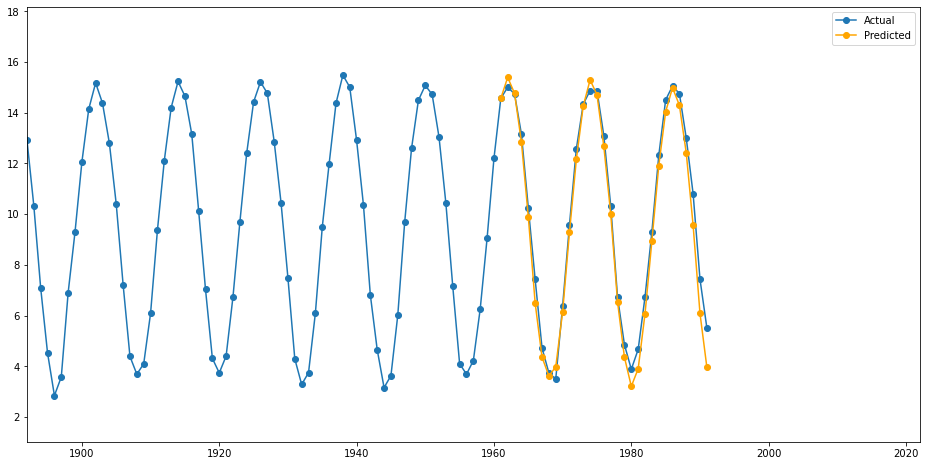

In [858]:
# plot forecasts
plot_predictions(series, preds, n_test+n_seq-1, test_index)

In [859]:
X_train_small = X_train[0:500]
y_train_small = y_train[0:500]
actual_small, preds_small = make_prediction(X_train_small, y_train_small, n_lag, n_seq, n_batch, n_epochs, n_neurons)

500/500 [==============================] - 0s 544us/step - loss: 0.0086 - mean_absolute_error: 0.0702


In [870]:
# evaluate predictions
rmse_avg, msle_avg, mae_avg = evaluate_predictions(actual_small, preds_small, n_lag, n_seq)
print("rmse_avg: ",rmse_avg, "msle_avg: ", msle_avg,"mae_avg: ", mae_avg )

t+1 RMSE: 0.389343 	 t+1 MSLE: 0.003752 	 t+1 MAE: 0.296569
t+2 RMSE: 0.461608 	 t+2 MSLE: 0.004332 	 t+2 MAE: 0.362169
t+3 RMSE: 0.522457 	 t+3 MSLE: 0.005300 	 t+3 MAE: 0.397003
t+4 RMSE: 0.525298 	 t+4 MSLE: 0.004856 	 t+4 MAE: 0.396546
t+5 RMSE: 0.590671 	 t+5 MSLE: 0.005472 	 t+5 MAE: 0.429351
t+6 RMSE: 0.617039 	 t+6 MSLE: 0.006380 	 t+6 MAE: 0.449587
t+7 RMSE: 0.536233 	 t+7 MSLE: 0.005046 	 t+7 MAE: 0.417170
t+8 RMSE: 0.534686 	 t+8 MSLE: 0.005396 	 t+8 MAE: 0.418516
t+9 RMSE: 0.514941 	 t+9 MSLE: 0.005480 	 t+9 MAE: 0.400526
t+10 RMSE: 0.554063 	 t+10 MSLE: 0.007266 	 t+10 MAE: 0.412052
t+11 RMSE: 0.568340 	 t+11 MSLE: 0.008047 	 t+11 MAE: 0.441944
t+12 RMSE: 0.609760 	 t+12 MSLE: 0.008185 	 t+12 MAE: 0.482826
t+13 RMSE: 0.608896 	 t+13 MSLE: 0.007644 	 t+13 MAE: 0.499742
t+14 RMSE: 0.578722 	 t+14 MSLE: 0.006476 	 t+14 MAE: 0.469307
t+15 RMSE: 0.606924 	 t+15 MSLE: 0.006186 	 t+15 MAE: 0.479585
t+16 RMSE: 0.638543 	 t+16 MSLE: 0.006577 	 t+16 MAE: 0.492356
t+17 RMSE: 0.649719

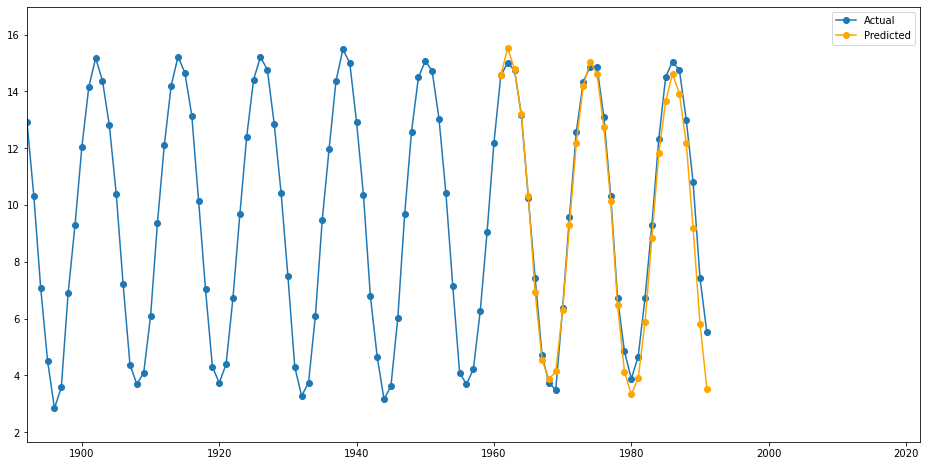

In [861]:
# plot forecasts
plot_predictions(series, preds_small, n_test+n_seq-1, test_index)

In [862]:
actual_noise, preds_noise = make_prediction(X_train, y_train, n_lag, n_seq, n_batch, n_epochs, n_neurons, True)


Added gaussian noise to model. 
1642/1642 [==============================] - 1s 526us/step - loss: 0.0182 - mean_absolute_error: 0.1063


In [868]:
# evaluate predictions
rmse_avg, msle_avg, mae_avg = evaluate_predictions(actual_noise, preds_noise, n_lag, n_seq)
print("rmse_avg: ",rmse_avg, "msle_avg: ", msle_avg,"mae_avg: ", mae_avg )

t+1 RMSE: 0.372933 	 t+1 MSLE: 0.003467 	 t+1 MAE: 0.288346
t+2 RMSE: 0.388316 	 t+2 MSLE: 0.003113 	 t+2 MAE: 0.304853
t+3 RMSE: 0.452880 	 t+3 MSLE: 0.004219 	 t+3 MAE: 0.367058
t+4 RMSE: 0.459978 	 t+4 MSLE: 0.004084 	 t+4 MAE: 0.370360
t+5 RMSE: 0.504910 	 t+5 MSLE: 0.004327 	 t+5 MAE: 0.412873
t+6 RMSE: 0.550695 	 t+6 MSLE: 0.004475 	 t+6 MAE: 0.438308
t+7 RMSE: 0.534835 	 t+7 MSLE: 0.004343 	 t+7 MAE: 0.416915
t+8 RMSE: 0.516602 	 t+8 MSLE: 0.004852 	 t+8 MAE: 0.402290
t+9 RMSE: 0.556630 	 t+9 MSLE: 0.007071 	 t+9 MAE: 0.436670
t+10 RMSE: 0.567380 	 t+10 MSLE: 0.007947 	 t+10 MAE: 0.451414
t+11 RMSE: 0.583092 	 t+11 MSLE: 0.007964 	 t+11 MAE: 0.452528
t+12 RMSE: 0.587370 	 t+12 MSLE: 0.006966 	 t+12 MAE: 0.456067
t+13 RMSE: 0.593897 	 t+13 MSLE: 0.005818 	 t+13 MAE: 0.472970
t+14 RMSE: 0.565733 	 t+14 MSLE: 0.004888 	 t+14 MAE: 0.456495
t+15 RMSE: 0.579737 	 t+15 MSLE: 0.004526 	 t+15 MAE: 0.476051
t+16 RMSE: 0.658694 	 t+16 MSLE: 0.005350 	 t+16 MAE: 0.541801
t+17 RMSE: 0.661924

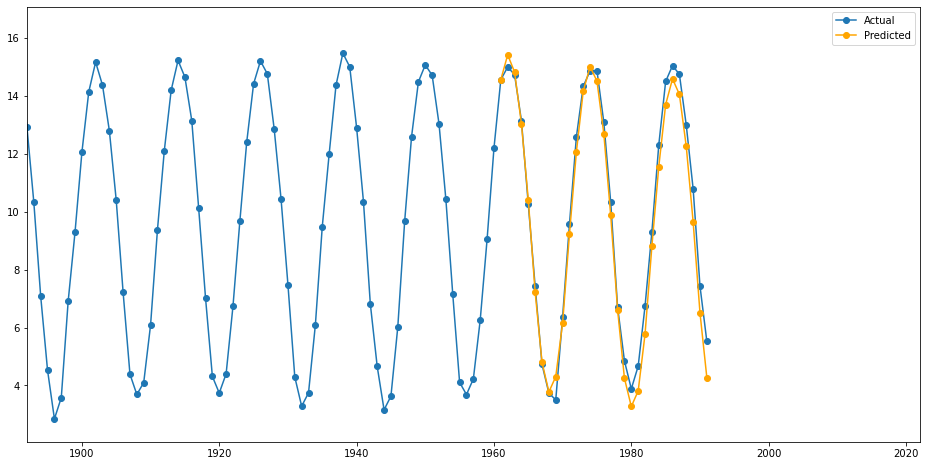

In [864]:
# plot forecasts
plot_predictions(series, preds_noise, n_test+n_seq-1, test_index)